## Analyze A/B Test Results

## Table of Contents
> - [Introduction](#intro)
> - [Data Cleaning/Wrangling](#data_cleaning/wrangling)
> - [Part I - Probability](#probability)
> - [Part II - A/B Test](#ab_test)
> - [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

> A/B tests are very commonly performed by data analysts and data scientists. It is used to test changes on a web page by running an experiment where a control group sees the old version, while the experiment group sees the new version. A metric is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other. A/B testing like hypothesis testing comprises of a null and alternative hypothesis.

<a id='intro'></a>
### Objectives

> This project involves working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. 

> The objective is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Data Cleaning/Wrangling

In [1]:
# Importing liraries to be used

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Reading the dataset into a variable and observing the first few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Checking the number of rows and columns using the shape function
df.shape

(294478, 5)

In [4]:
# Checking the number of unique users in the unique_id column

df.user_id.nunique()

290584

In [5]:
# Calculating the proportion of users converted

df['converted'].mean()

0.11965919355605512

In [6]:
# Computing for the number of times the treatment group was mismatched with the old_page instead of the new_page,

df[(df['group'] == "treatment") != (df['landing_page'] =="new_page")].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [7]:
# Computing for the numer of rows with missing data

df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore inorder to improve the accuracy of the dataset to be tested, these rows are removed. 

> After the rows are removed, a new dataset is created and stored in a new dataframe in **df2**.

In [8]:
# assigning the index of rows in which the new_page and treatment dont match to a variable

d = df[(df['group'] == "treatment") != (df['landing_page'] =="new_page")].index

In [9]:
# dropping the index of rows assigned to variable d from the df dataframe and assigning the remaining rows to a new dataframe df2

df2 = df.drop(d)

In [10]:
# Checking for the shape of the new dataset

df2.shape

(290585, 5)

In [11]:
# Doublecheckong to see if all of the correct rows were removed 

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [12]:
# Checking for the number of unique user_ids in the new dataframe df2

df2.user_id.nunique()

# It is observed that there seems to be a duplicated user_id as the number of unique user_ids is less than the number of rows of the entire dataset.

290584

In [13]:
# Checking for the duplicate user_id by using the value_counts function

df2.user_id.value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
         ..
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

In [14]:
# Finding the row information of the duplicate id

df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# Removing one of the rows with the duplicate user_id using the row index
df2.drop(2893, inplace=True)

<a id='intro'></a>
### Part I - Proability

In [16]:
# Finding the probability of an individual converting regardless of the page received

df2.converted.mean()

0.11959708724499628

In [17]:
# Finding the probability that an individual in the control group converted.

df2.query('group == "control"')['converted'].mean()

0.1203863045004612

In [18]:
# Finding the probability of an individual that was in the treatment group and converted.

df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [19]:
# finding the probability that an individual received the new page

(df2.landing_page == "new_page").mean()

0.5000619442226688

> It is observed that the probability an individual receiving the new page  is approximately equal regardless of the group. From the analysis carried out and probability obtained for both the control and experiment groups, there is no sufficient evidence to show that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

> Considering the need to make a decision just based on all the data provided, it is assumed that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

> At a type 1 error rate of 5%, the null and alternative hypothesis in terms of notations **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pag are given as:

> * $H_0 : P_{new} - P_{old} =< 0$ 
> * $H_1 : P_{new} - P_{old} > 0$ 

> If under the null hypothesis, it is assumed that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - then $p_{new}$ and $p_{old}$ are equal. Furthermore, it is also assumed they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

> The null and alternative hypothesis will therefore be given as;

> * $H_0 : P_{new} - P_{old} = 0$ 
> * $H_1 : P_{new} - P_{old} != 0$ 

In [20]:
# Computing the conversion rate for p_new under the null

p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [21]:
# Computing the conversion rate for p_old under the null

p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [22]:
# Finding the number of individuals in the treatment group

n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

In [23]:
# Finding the number of individuals in the control group

n_old = df2.query('group == "control"').shape[0]
n_old

145274

In [24]:
# calculating the difference between the conversion rates for p_new and p_old under the null.

p_new - p_old

0.0

> Using a sample size for each page equal to the ones in **ab_data.csv**, the sampling distribution is computed for the difference in **converted** between the two pages over 10,000 iterations.

In [25]:
# Simulating n_new transactions with a conversion rate of p_new under the null

new_page_converted = np.random.choice([0,1], size=n_new, p = [1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

In [26]:
# Simulating n_old transactions with a conversion rate of p_old under the null 

old_page_converted = np.random.choice([0,1], size=n_old, p = [1-p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# Calculating the differences between the mean simulated conversion rates for the new and old page.

pnew = new_page_converted.mean()
pold = old_page_converted.mean()
pnew - pold

-0.0008346354424162566

In [28]:
# Creating 10000 simulations of the differences between the mean conversion rates for the new and old page

p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p = [1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p = [1-p_old, p_old])
    pnew = new_page_converted.mean()
    pold = old_page_converted.mean()
    p_diffs.append(pnew - pold)

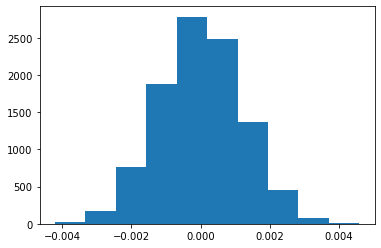

In [29]:
# Ploting a histogram for the distribution of the simulated differences

p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

In [30]:
# Computing the observed difference in conversion rates between the control and experiment groups in the a_data.csv

control = df2.query('group == "control"')['converted'].mean()
treatment = df2.query('group == "treatment"')['converted'].mean()
obs_diff = treatment - control
obs_diff

-0.0015782389853555567

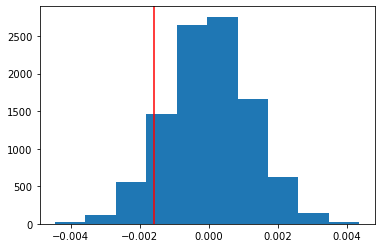

In [31]:
# Simulating the distribution from the null and finding the probability that the observed statistic came from this distribution.

null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(x= obs_diff, color = 'r');

In [32]:
# Finding the proportion of p_diffs greater than the observed actual difference

p_val = (p_diffs > obs_diff).mean()
p_val

0.9055

> The value computed above is referred to as the P-value. The P-value against the type 1 error rate is used to measure the statistical significance and determine whether to fail to reject the null hypothesis or to reject the null hypothesis. In this case, the p-value of 0.91 against the type 1 error rate of 0.05 indicates that we fail to reject the null hypothesis. Therefore, in staying with the null hypothesis the new page does not effect any change on the conversion rate.

> A built-in formula can also be used to achieve a similar result. Although using the built-in might be easier to code, the above portions are also walkthrough of the ideas critical to correctly thinking about statistical significance.

In [33]:
import statsmodels.api as sm
# Calculating the number of conversions for each page

convert_old = df2.query('landing_page == "old_page" & converted == "1"').shape[0]
convert_new =  df2.query('landing_page == "new_page" & converted == "1"').shape[0]

In [34]:
# Calculating the total number of individuals who received each page

n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [35]:
convert_old, convert_new

(17489, 17264)

In [36]:
n_old, n_new

(145274, 145310)

In [37]:
# Using stats.proportions_ztest to compute the test statistic(z-score) and p-value

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

> The `z-score` of 1.3 and `p-value` of 0.91 also corresponds to the findings using the simulated differences. When measured against an error rate of 0.05, the small `z-score` and high `p-value` indicates that we should fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

> The result achieved in the A/B test in Part II above can also be achieved by performing regression. In this case, since each row has only two outcomes i.e. either a conversion or non-conversion in binary form, a Logistic Regression is the type of regression to be perfomed.

> This involves using **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.

In [38]:
# Creating and intercept column in the df2 dataframe

df2['intercept'] = 1


In [39]:
# Creating a dummy variable for each page a user received by adding an ab_page column
# which is 1 when an individual receives the treatment and 0 if control

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

# Confirming the intercept and ab_page column is a part of the df2 dataframe

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [40]:
# Using statsmodel to Instantiate and fit the model to predict whether or not an individual converts based on the type of page received

log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [41]:
# Summary of the model created
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-08-17 19:50 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

> The p-value associated with `ab_page` from the logistic regression is given as 0.1899. This p-value differs totally from that obtained using A/B testing and the inbuilt `stats.proportions_z` test function. This is because the hypothesis test for the logistic regression is a two-tailed test while that for the A/B testing is a one-tailed test.

> Although the p-value between the simulated and observed difference and the p-value obtained from the logistic regression are different in values, they both do not show any statistical significance. They two p-values support the decision to fail to reject the null and show that the new page does not improve the conversion rate.


> Adding other factors into a regression model help to improve the prediction of the response variable, although this may change the statistical significance of previous variables present in the model and the model may give unpredictable results. This is most likely due to multicollinearity between the variables.

> Along with testing if the conversion rate changes for different pages, an effect based on which country a user lives in will be added by reading in the **countries.csv** dataset and merging it together with the `df2` dataset on the appropriate rows. 
> On the merged dataset, a regression model is created to measure if the country has an impact on the conversion rate.

In [42]:
# Reading the countries dataset into a dataframe

dff = pd.read_csv('countries.csv')
dff.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# Checking for the number of unique values in the country column

dff.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [44]:
# Creating a new dataframe by merging the countries dataset with the df2 dataset Using the merge() function

df_all = pd.merge(df2, dff, on='user_id', how="inner")
df_all.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [45]:
# Creating dummy variables for the country dataset
df_all[['UK', 'US', 'CA']] = pd.get_dummies(df_all['country'])

# Using the CA dummy variable as a baseline therefore it is dropped
df_all.drop('CA', axis=1, inplace=True)

# Checking to confirm that the baseline has been dropped
df_all.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


In [46]:
# Instantiating and fitting a model to check for the impact of country on conversion rate
log_mod = sm.Logit(df_all['converted'], df_all[['intercept', 'UK', 'US']])
result1 = log_mod.fit()

# Checking for the summary of the model fitted
result1.summary2()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2020-08-17 19:50 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
US            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

> From the summary above of the fitted model obtained to measure the impact of country on the conversion rate, the p-values of both `UK`  and `US` are higher than the error rate of 0.05. It therefore appears that the country a user lives in therefore has no impact on the conversion rate.

> After observing the individual factors of country and page on the conversion rate, an interaction between page and country will be observed to see if there are any significant effects on the conversion rate.

In [47]:
# Creating a columns containing the interaction between page and country
df_all['UK_page'] = df_all['UK'] * df_all['ab_page']
df_all['US_page'] = df_all['US'] * df_all['ab_page']

In [48]:
# Instantiating and fitting a model to check for the impact of both ab_page and country on the conversion rate
logistic_mod = sm.Logit(df_all['converted'], df_all[['intercept', 'ab_page', 'UK', 'US', 'UK_page', 'US_page']])
results = logistic_mod.fit()

# Checking for the summary of the model fitted
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-08-17 19:50 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
UK_page      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
US_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

<a id='conclusions'></a>
## Conclusion

> A logistic regression can be used as an alternative way to confirm the results of AB testing. In this project creating a logistic model to predict the impact of the page a user received, the country a user lives in and the interaction between the page an d country gives a summary with p-values greater than 0.05. These p-values are not statistically significant and therefore indicate that the variables page and country or the interaction between these variables do not have any significant effect on the conversion rate.

> In conclusion, the new page does not improve the conversion rate and we therefore fail to reject the null hypothesis. The company is therefore advised to continue using the old page as there's no statistical significance to show that the new page will improve the conversion rate.